# ARFS - Non Normal loss and Sample Weight

Feel free to choose any loss function that suits your needs, whether it's one provided by the library or a custom one that you define. The underlying estimator should support the use of custom loss functions for you to take full advantage of this flexibility.

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import arfs
from arfs.feature_selection import GrootCV, Leshy, BoostAGroota, make_fs_summary
from arfs.feature_selection import MinRedundancyMaxRelevance
from arfs.utils import load_data
from arfs.benchmark import highlight_tick

rng = np.random.RandomState(seed=42)


def plot_y_vs_X(
    X: pd.DataFrame, y: pd.Series, ncols: int = 2, figsize: tuple = (10, 10)
) -> plt.Figure:
    """
    Create subplots of scatter plots showing the relationship between each column in X and the target variable y.

    Parameters
    ----------
        X : pd.DataFrame
            The input DataFrame containing the predictor variables.
        y : pd.Series
            The target variable to be plotted against.
        ncols : int, optional (default: 2)
            The number of columns in the subplot grid.
        figsize : tuple, optional (default: (10, 10))
            The size of the figure (width, height) in inches.

    Returns
    -------
        plt.Figure
            The generated Figure object containing the scatter plots.
    """

    n_rows, ncols_to_plot = divmod(X.shape[1], ncols)
    n_rows += int(ncols_to_plot > 0)

    # Create figure and axes
    f, axs = plt.subplots(nrows=n_rows, ncols=ncols, figsize=figsize)

    # Iterate through columns and plot against y
    for ax, col in zip(axs.flat, X.columns):
        ax.scatter(X[col], y, alpha=0.1)
        ax.set_title(col)

    # Remove any unused subplots
    for ax in axs.flat[len(X.columns) :]:
        ax.set_axis_off()

    # Display the figure
    plt.tight_layout()
    return f

The true coefficient of the linear data generating process are:
 intercept     1.000000
pred_0        0.000000
pred_1       77.903644
pred_2        0.000000
pred_3        0.000000
pred_4       63.702300
pred_5        0.000000
pred_6       95.594997
pred_7       43.869903
pred_8        0.000000
pred_9        4.118619
dtype: float64


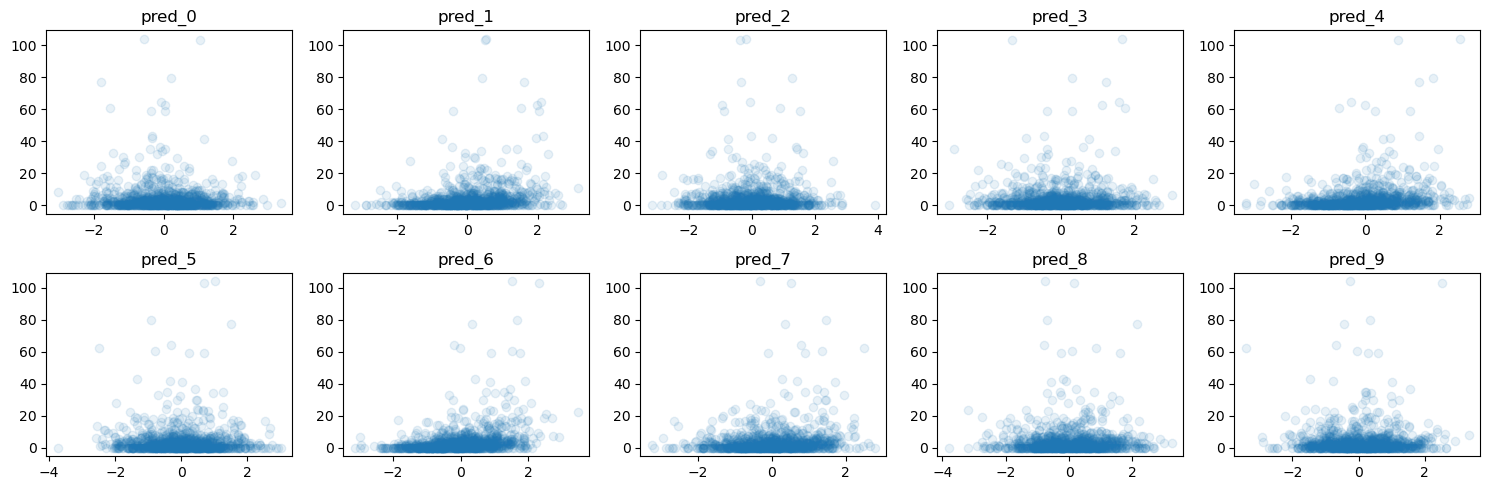

In [2]:
# Generate synthetic data with Poisson-distributed target variable
bias = 1
X, y, true_coef = make_regression(
    n_samples=2_000,
    n_features=10,
    n_informative=5,
    noise=1,
    random_state=8,
    bias=bias,
    coef=True,
)
y = (y - y.mean()) / y.std()
y = np.exp(y)  # Transform to positive values for Poisson distribution
y = np.random.poisson(y)  # Add Poisson noise to the target variable
# dummy sample weight (e.g. exposure), smallest being 30 days
w = np.random.uniform(30 / 365, 1, size=len(y))
# make the count a Poisson rate (frequency)
y = y / w

X = pd.DataFrame(X)
X.columns = [f"pred_{i}" for i in range(X.shape[1])]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.5, random_state=42
)

true_coef = pd.Series(true_coef)
true_coef.index = X.columns
true_coef = pd.Series({**{"intercept": bias}, **true_coef})
true_coef

genuine_predictors = true_coef[true_coef > 0.0]

print(f"The true coefficient of the linear data generating process are:\n {true_coef}")

f = plot_y_vs_X(X_train, y_train, ncols=5, figsize=(15, 5))

In [3]:
genuine_predictors

intercept     1.000000
pred_1       77.903644
pred_4       63.702300
pred_6       95.594997
pred_7       43.869903
pred_9        4.118619
dtype: float64

illustrating the pipelining

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

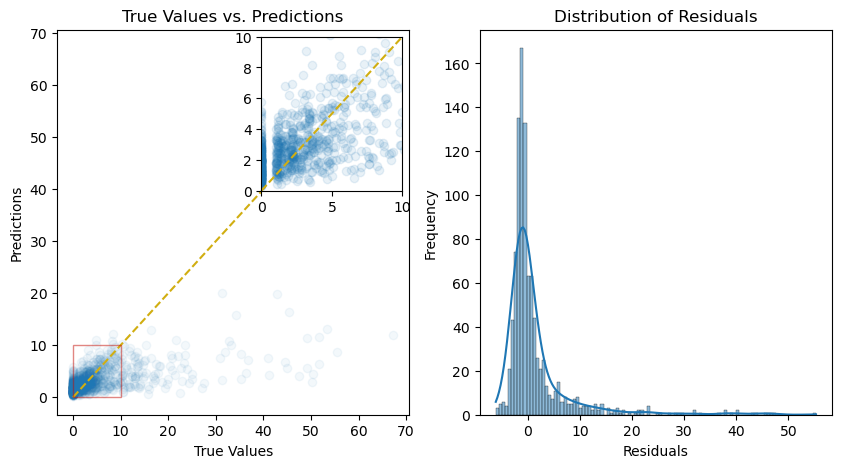

In [4]:
# Create a pipeline with LassoFeatureSelection and LinearRegression
pipeline = Pipeline(
    [
        ("scaler", StandardScaler().set_output(transform="pandas")),
        (
            "selector",
            GrootCV(
                objective="poisson",
                cutoff=1,
                n_folds=5,
                n_iter=5,
                silent=True,
                fastshap=True,
                n_jobs=0,
            ),
        ),
        ("glm", PoissonRegressor()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(
    X_train, y_train, selector__sample_weight=w_train, glm__sample_weight=w_train
)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predictions and residuals
plt.figure(figsize=(10, 5))

# Plot predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.05)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")

# Inset zoom of the first panel
ax = plt.gca()
axins = inset_axes(ax, width="40%", height="40%", loc="upper right")
axins.scatter(y_test, y_pred, alpha=0.1)
axins.plot([0, 10], [0, 10], color="#d1ae11", linestyle="--")
axins.set_xlim(0, 10)
axins.set_ylim(0, 10)
ax.indicate_inset_zoom(axins, edgecolor="#c40f06")

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

plt.show()

The selected features: ['pred_1' 'pred_4' 'pred_6' 'pred_7']
The agnostic ranking: [1 2 1 1 2 1 2 2 1 1]
The naive ranking: ['pred_6', 'pred_1', 'pred_4', 'pred_7', 'pred_2', 'pred_8', 'pred_5', 'pred_0', 'pred_9', 'pred_3']


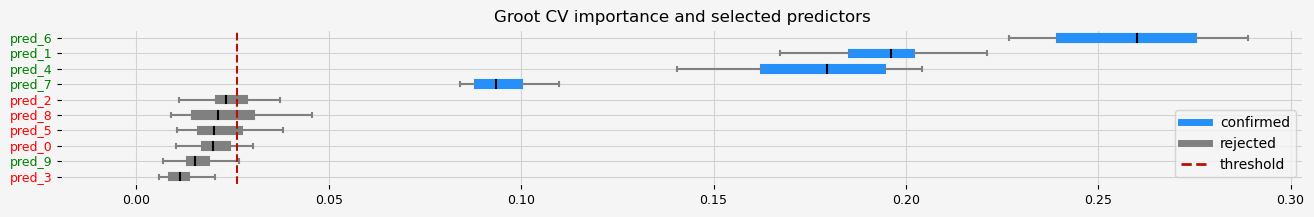

In [5]:
print(
    f"The selected features: {pipeline.named_steps['selector'].get_feature_names_out()}"
)
print(f"The agnostic ranking: {pipeline.named_steps['selector'].ranking_}")
print(f"The naive ranking: {pipeline.named_steps['selector'].ranking_absolutes_}")
fig = pipeline.named_steps["selector"].plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
for name in true_coef.index:
    if name in genuine_predictors.index:
        fig = highlight_tick(figure=fig, str_match=name, color="green")
    else:
        fig = highlight_tick(figure=fig, str_match=name)

plt.show()

In [6]:
make_fs_summary(pipeline)

,predictor,scaler,selector,glm
0,pred_0,nan,0,nan
1,pred_1,nan,1,nan
2,pred_2,nan,0,nan
3,pred_3,nan,0,nan
4,pred_4,nan,1,nan
5,pred_5,nan,0,nan
6,pred_6,nan,1,nan
7,pred_7,nan,1,nan
8,pred_8,nan,0,nan
9,pred_9,nan,0,nan


## Leshy

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	3
All relevant predictors selected in 00:00:01.22


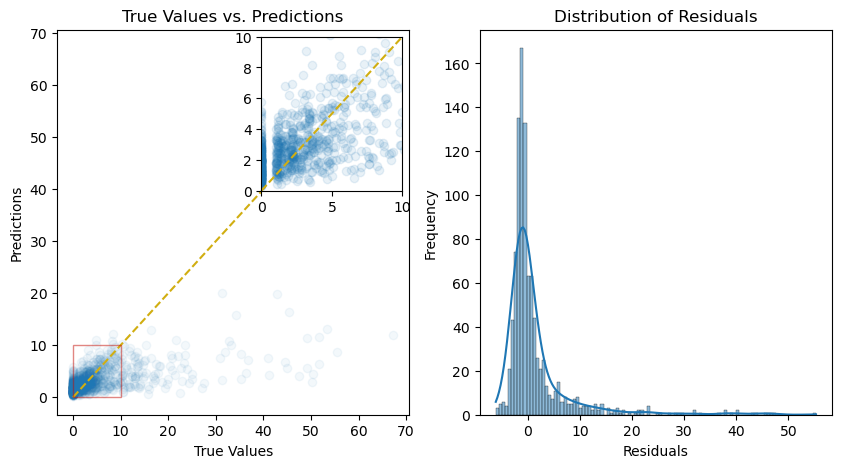

In [7]:
model = LGBMRegressor(random_state=42, verbose=-1, objective="poisson")

pipeline = Pipeline(
    [
        ("scaler", StandardScaler().set_output(transform="pandas")),
        (
            "selector",
            Leshy(
                model,
                n_estimators=20,
                verbose=1,
                max_iter=10,
                random_state=42,
                importance="fastshap",
            ),
        ),
        ("glm", PoissonRegressor()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(
    X_train, y_train, selector__sample_weight=w_train, glm__sample_weight=w_train
)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predictions and residuals
plt.figure(figsize=(10, 5))

# Plot predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.05)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")

# Inset zoom of the first panel
ax = plt.gca()
axins = inset_axes(ax, width="40%", height="40%", loc="upper right")
axins.scatter(y_test, y_pred, alpha=0.1)
axins.plot([0, 10], [0, 10], color="#d1ae11", linestyle="--")
axins.set_xlim(0, 10)
axins.set_ylim(0, 10)
ax.indicate_inset_zoom(axins, edgecolor="#c40f06")

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

plt.show()

The selected features: ['pred_1' 'pred_4' 'pred_6' 'pred_7']
The agnostic ranking: [2 1 3 5 1 2 1 1 2 4]
The naive ranking: ['pred_6', 'pred_1', 'pred_4', 'pred_7', 'pred_0', 'pred_5', 'pred_8', 'pred_2', 'pred_9', 'pred_3']


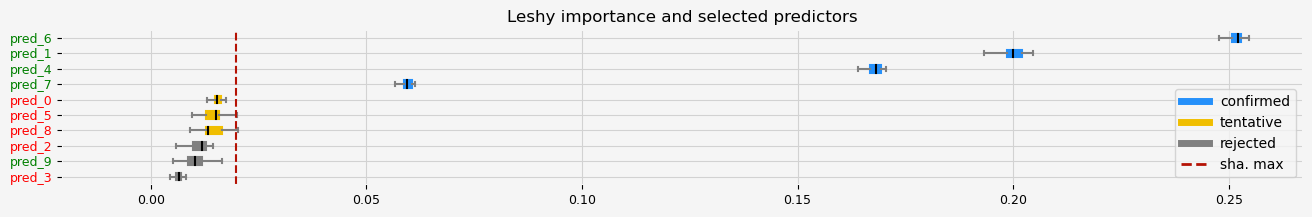

In [8]:
print(
    f"The selected features: {pipeline.named_steps['selector'].get_feature_names_out()}"
)
print(f"The agnostic ranking: {pipeline.named_steps['selector'].ranking_}")
print(f"The naive ranking: {pipeline.named_steps['selector'].ranking_absolutes_}")
fig = pipeline.named_steps["selector"].plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
for name in true_coef.index:
    if name in genuine_predictors.index:
        fig = highlight_tick(figure=fig, str_match=name, color="green")
    else:
        fig = highlight_tick(figure=fig, str_match=name)

plt.show()
plt.show()

## BoostAGRoota

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

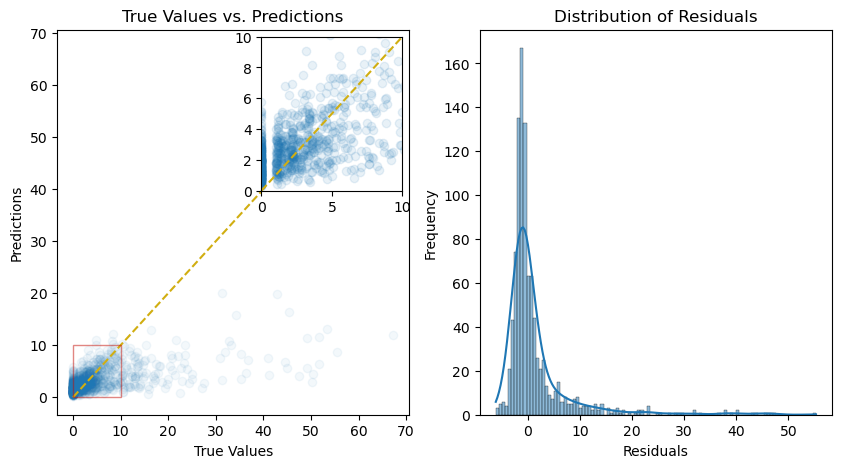

In [9]:
model = LGBMRegressor(random_state=42, verbose=-1, objective="poisson")

pipeline = Pipeline(
    [
        ("scaler", StandardScaler().set_output(transform="pandas")),
        (
            "selector",
            BoostAGroota(
                estimator=model,
                cutoff=1,
                iters=10,
                max_rounds=10,
                delta=0.1,
                importance="fastshap",
            ),
        ),
        ("glm", PoissonRegressor()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(
    X_train, y_train, selector__sample_weight=w_train, glm__sample_weight=w_train
)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predictions and residuals
plt.figure(figsize=(10, 5))

# Plot predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.05)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")

# Inset zoom of the first panel
ax = plt.gca()
axins = inset_axes(ax, width="40%", height="40%", loc="upper right")
axins.scatter(y_test, y_pred, alpha=0.1)
axins.plot([0, 10], [0, 10], color="#d1ae11", linestyle="--")
axins.set_xlim(0, 10)
axins.set_ylim(0, 10)
ax.indicate_inset_zoom(axins, edgecolor="#c40f06")

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

plt.show()

The selected features: ['pred_1' 'pred_4' 'pred_6' 'pred_7']
The agnostic ranking: [1 2 1 1 2 1 2 2 1 1]
The naive ranking: ['pred_6', 'pred_1', 'pred_4', 'pred_7', 'pred_5', 'pred_0', 'pred_8', 'pred_9', 'pred_2', 'pred_3']


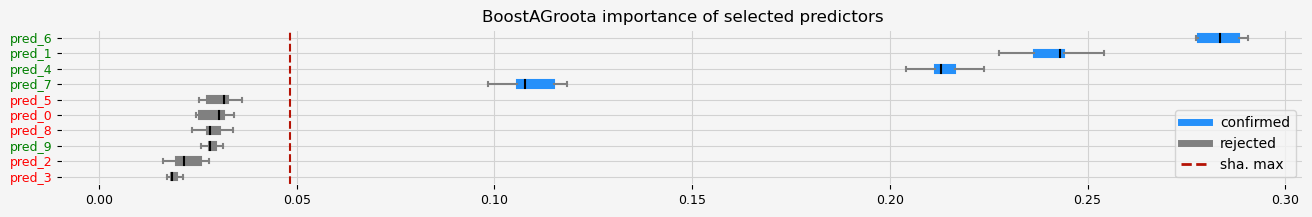

In [10]:
print(
    f"The selected features: {pipeline.named_steps['selector'].get_feature_names_out()}"
)
print(f"The agnostic ranking: {pipeline.named_steps['selector'].ranking_}")
print(f"The naive ranking: {pipeline.named_steps['selector'].ranking_absolutes_}")
fig = pipeline.named_steps["selector"].plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
for name in true_coef.index:
    if name in genuine_predictors.index:
        fig = highlight_tick(figure=fig, str_match=name, color="green")
    else:
        fig = highlight_tick(figure=fig, str_match=name)

plt.show()

## MRmr

  0%|          | 0/5 [00:00<?, ?it/s]

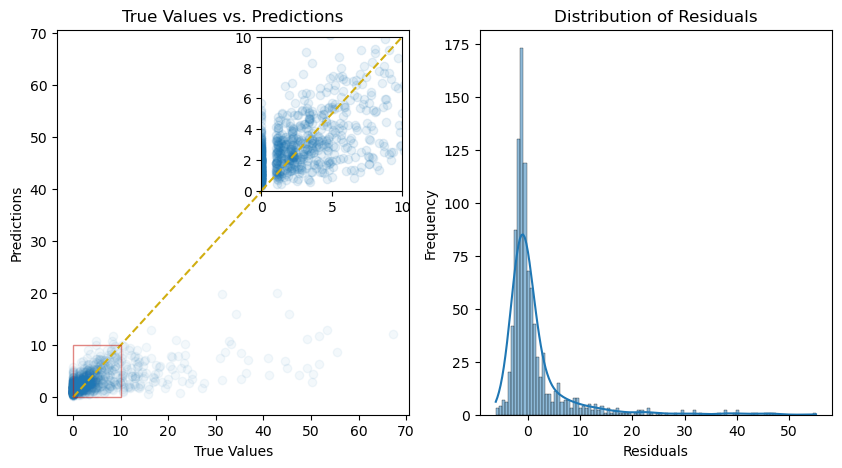

In [11]:
mrmr = MinRedundancyMaxRelevance(
    n_features_to_select=5,
    relevance_func=None,
    redundancy_func=None,
    task="regression",  # "classification",
    denominator_func=np.mean,
    only_same_domain=False,
    return_scores=False,
    show_progress=True,
    n_jobs=-1,
)

pipeline = Pipeline(
    [
        ("selector", mrmr),
        ("scaler", StandardScaler().set_output(transform="pandas")),
        ("glm", PoissonRegressor()),
    ]
)

# Fit the pipeline to the training data
pipeline.fit(
    X_train,
    pd.Series(y_train),
    selector__sample_weight=pd.Series(w_train),
    glm__sample_weight=w_train,
)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Plot the predictions and residuals
plt.figure(figsize=(10, 5))

# Plot predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.05)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="#d1ae11",
    linestyle="--",
)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs. Predictions")

# Inset zoom of the first panel
ax = plt.gca()
axins = inset_axes(ax, width="40%", height="40%", loc="upper right")
axins.scatter(y_test, y_pred, alpha=0.1)
axins.plot([0, 10], [0, 10], color="#d1ae11", linestyle="--")
axins.set_xlim(0, 10)
axins.set_ylim(0, 10)
ax.indicate_inset_zoom(axins, edgecolor="#c40f06")

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

plt.show()

In [12]:
genuine_predictors

intercept     1.000000
pred_1       77.903644
pred_4       63.702300
pred_6       95.594997
pred_7       43.869903
pred_9        4.118619
dtype: float64

In [18]:
print(
    f"The selected features: {pipeline.named_steps['selector'].get_feature_names_out()}"
)

The selected features: ['pred_1' 'pred_3' 'pred_4' 'pred_6' 'pred_7']


In [16]:
pipeline.named_steps["selector"].ranking_

,mrmr,relevance,redundancy
pred_6,inf,2.171536,0.000000
pred_1,526.407890,1.172257,0.002227
pred_4,13.920838,0.590120,0.042391
pred_7,-0.423440,-0.013767,0.032512
pred_3,-13.498772,-0.656412,0.048628
